In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math

from dataset import get_dataset
from metrics import Metrics

In [2]:
_, _, data_np = get_dataset(name="electricity", window_len=1, cxt_len=1, pred_len=1)

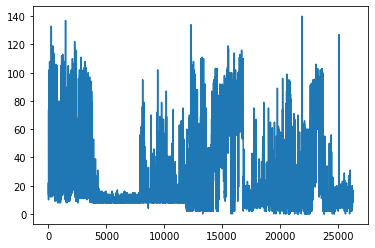

In [3]:
plt.plot(data_np[0])

In [4]:
pred_len = 200
window_len = 500

train_ds = torch.tensor(data_np[:, :-pred_len])
test_ds = torch.tensor(data_np[:, -pred_len:])

In [5]:
def create_inout_sequences(input_data, window_len, pred_len = 1):
    L = len(input_data)
    x = torch.empty([L-window_len, window_len ,1])
    y = torch.empty([L-window_len ,1])
    for i in range(L-window_len):
        x[i, :, 0] = input_data[i:i+window_len]
        y[i, 0] = input_data[i+window_len:i+window_len+pred_len]
    return x, y

In [6]:
class LSTM(nn.Module):
    def __init__(self, num_outputs = 2, input_size = 1, hidden_size = 100, num_layers = 1):
        super(LSTM, self).__init__()
        
        self.num_outputs = num_outputs
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_outputs)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size)
        # Propagate input through LSTM
        output, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        out[:, 1] = torch.log(1 + torch.exp(out[:, 1])) # variance
        
        return out

In [7]:
def NLLloss(y, mean, var):
    """ Negative log-likelihood loss function. """
    return (torch.log(var) + torch.pow(y - mean, 2)/var).sum()

In [ ]:
num_epochs = 10
learning_rate = 0.0001
batch_size = 1000

input_size = 1
hidden_size = 100
num_layers = 1
num_outputs = 2

lstm = LSTM(num_outputs, input_size, hidden_size, num_layers)

optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for i in range(len(train_ds)):
        optimizer.zero_grad()
        loss = 0
        train_x, train_y = create_inout_sequences(train_ds[i], window_len)
        num_batch = math.ceil(train_x.shape[0] / batch_size)
        for j in range(num_batch):
            outputs = lstm(train_x[(i * batch_size) : ((i+1) * batch_size), :, :])
            loss += NLLloss(train_y[(i * batch_size) : ((i+1) * batch_size), :], outputs[:, 0], outputs[:, 1])
        loss /= train_x.shape[0]
        loss.backward()
        optimizer.step()
        
        print("Epoch: %d, series: %d, loss: %1.5f" % (epoch, i, loss.item()))

Epoch: 0, series: 0, loss: 4.36072
Epoch: 0, series: 1, loss: 16.10914
Epoch: 0, series: 2, loss: 0.13938
Epoch: 0, series: 3, loss: 191.64491
Epoch: 0, series: 4, loss: 53.16714
Epoch: 0, series: 5, loss: 694.49451
Epoch: 0, series: 6, loss: 0.23642
Epoch: 0, series: 7, loss: 1796.05823
Epoch: 0, series: 8, loss: 121.71937
Epoch: 0, series: 9, loss: 110.18833
Epoch: 0, series: 10, loss: 34.00537
Epoch: 0, series: 11, loss: 132.35208
Epoch: 0, series: 12, loss: 35.45966
Epoch: 0, series: 13, loss: 31.41242
Epoch: 0, series: 14, loss: 61.61059
Epoch: 0, series: 15, loss: 1239.52332
